I want code that I can reuse for arbitrary jurisdictions that are contained in the John Hopkins data. Those 3 fields are Admin2, Province_State, and Country_Region.

In [204]:
# import libraries
from datetime import timedelta
import matplotlib.pyplot as plt 
plt.rcParams['figure.figsize'] = (12,8)
import pandas as pd
import numpy as np
import seaborn as sb
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller

In [205]:
def data_merge(arg_dict):
    """Read files off disk and merge those 2 files"""
    
    # Read in dfs
    df = pd.read_csv(arg_dict['file_name_1'])
    country_codes_df = pd.read_csv(arg_dict['file_name_2'])
    
    # Lets rename the 3 letter code column
    country_codes_df.rename({'ISO3166-1-Alpha-3': 'Alpha_3'}, axis=1, inplace =True)
    
    # We only want Country_Region and Alpha_3
    country_codes_df = country_codes_df[['Country_Region', 'Alpha_3']]
    
    # Merge the 2 dfs
    df_cc = df.merge(country_codes_df)
    
    return df_cc


In [206]:
def restrict_column_place(df, arg_dict):
    """Take the input df and return a df that is restricted to column (feature) and place"""
    
    # Put df on a diet
    df = df[['Date_', arg_dict['feature'], arg_dict['dependent_variable']]] 
    
    # Restrict to place
    df = df[df[arg_dict['feature']] == arg_dict['place']] 
    
    # Might have an incorrect place name
    if len(df) > 0:
        
        # Create a groupby on Date_. 
        # Since we only have the 'place' left we have the df we want in sorted order with Date_ as the index.
        df_gb = df.groupby('Date_').sum()
        
    else:
        print('We have a challenge. df_gb is empty. def restrict_columnn_place')
        return df_gb
        
    return df_gb


Occasionally there are data corrections that occur. This causes downstream machine learning challenges with plotting and the ARIMA model. Deal with this here now, by taking the mean of the outliers on those dates.

If Daily_Deaths is negative, we have a problem. Take the average of the before Deaths row and the after Deaths row and use that as a plug value for the Deaths row where the Daily Deaths went negative.

We could fix this with a .apply. However, that would loop thru a million plus rows and would take a long time. Lets use vector operations with Pandas.

First identify all of the negative instances. Take those rows PLUS the row before and row after and put them in a new temporary dataframe. You don't have to put the rows back in the df since Pandas uses pointers. The temp dfs are actually updating the original df.

In [207]:
def data_clean(df, arg_dict):
    """There is some data cleaning required"""
    
    # Nulls are not a challenge. However, there are parts of this dataset where deaths are 0
    df = df[df[arg_dict['dependent_variable']] != 0]
    
    # Create a Daily Deaths column
    df['Daily_Deaths'] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
    
    # Save the index 
    df_index = df.index
    
    # Create a datetime index so that you can do date calculations
    df.index = pd.to_datetime(df.index)
    
    # Restrict this to just the offending rows.
    temp = df[df['Daily_Deaths'] < 0]
    
    print(temp)
    
    # Create a list with the offending dates.
    row_index_list = []
    for row in temp.itertuples():
        row_index = row.Index
        row_index_list.append(row_index)
    
    # Fix offending values
    for idx in range(len(row_index_list)):
    
        # Get start and end dates of rows of interest
        start_date_row = row_index_list[idx] - timedelta(days=1)
        end_date_row = row_index_list[idx] + timedelta(days=1)

        # Now that we have the rows, start the adjustments
        temp2 = df.loc[start_date_row: end_date_row, :]

        # Mean for Deaths
        temp2.iloc[1,0] = (temp2.iloc[0,0] + temp2.iloc[2,0]) / 2
        
    # Put the string index back in place
    df.index = df_index
        
    # Don't bother fixing Daily_Deaths. Just drop it.
    df.drop('Daily_Deaths', axis=1, inplace=True) 
    
    return df

In [208]:
def load_prepare(df, arg_dict):
    """Load the data, difference, and return series"""
    
    # difference the data using shift
    new_col = "Daily_" + arg_dict['dependent_variable']
    df[new_col] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()

    # return the series, except for first row which is NaN
    return df[new_col][1:]


In [209]:
def check_stationary(stationary, arg_dict):
    """Look at some statistics and graphs to see if the dataset is now stationary"""

    # check if stationary
    result = adfuller(stationary)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    # plot differenced data
    stationary.plot()
    plt.xlabel('Date')
    plt.ylabel(arg_dict['dependent_variable'])
    plt.title('Differenced Data')
    plt.show();

    # save
    stationary.to_csv(r'data/stationary.csv', header=False)
    

In [210]:
def acf_pacf_plots(series):
    """ACF and PACF plots of the time series"""

    plt.figure(figsize=(16,6))
    plt.subplot(211)
    plot_acf(series, ax=plt.gca())
    plt.subplot(212)
    plot_pacf(series, ax=plt.gca())
    plt.show()

In [211]:
def driver(arg_dict):
    """This is the main driver program that pushes the program thru its execution"""
    
    # Start the data preparation by merging the 2 files
    df = data_merge(arg_dict)
    
    # Restrict the resulting df to the column (feature) and place that you want
    df = restrict_column_place(df, arg_dict)  
    
    # Clean up the data
    df = data_clean(df, arg_dict)
    
    # Load the data and create a stationary dataset
    stationary = load_prepare(df, arg_dict)
    
    # Check if stationary, print, statistics and plot the differenced data
    check_stationary(stationary, arg_dict)
    
    # ACF and PACF plots of the time series
    series = df[arg_dict['dependent_variable']] # These are the original values.
    acf_pacf_plots(series)
    
    return df


C:\anaconda3\envs\py38\lib\site-packages\IPython\core\interactiveshell.py:3427: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
<ipython-input-207-52b66862c50e>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Daily_Deaths'] = df[arg_dict['dependent_variable']] - df[arg_dict['dependent_variable']].shift()
C:\anaconda3\envs\py38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, va

              Deaths  Daily_Deaths
Date_                             
2021-01-28  316813.0     -113795.0
ADF Statistic: -1.388818
p-value: 0.587625
Critical Values:
	1%: -3.450
	5%: -2.870
	10%: -2.571


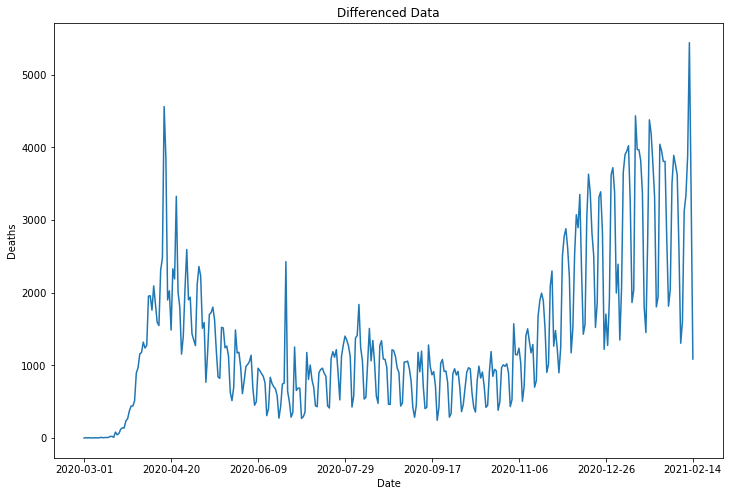

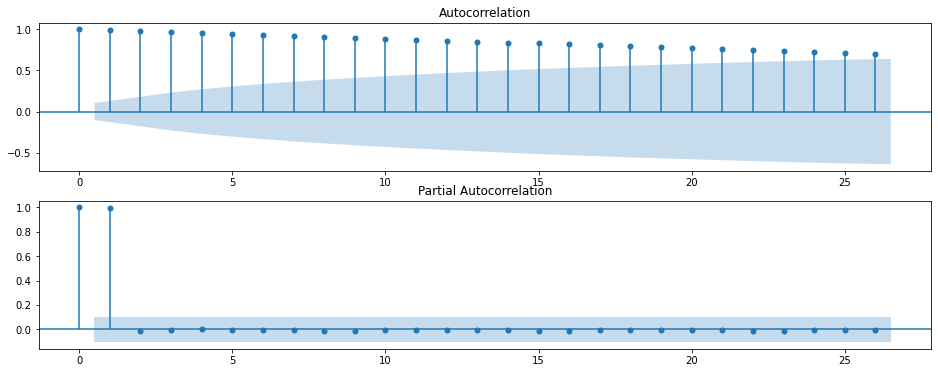

In [212]:
if __name__ == '__main__':
    
    # Prepare arguments for driver
    arg_dict = {'file_name_1': r'data\all_df.csv',
                'file_name_2': r'C:\Users\Lindsay Moir\OneDrive\Documents\GitHub\covid\data\country_codes_edited.csv',
                'feature': 'Alpha_3',
                'place': 'USA',
                'dependent_variable': 'Deaths'}
    
    # Start driver
    df = driver(arg_dict)
    